In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from utils.text import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import NMF
from scipy.sparse import coo_matrix, find

run_id = 338
stat = RunStats.objects.get(pk=run_id)
q = stat.query
print(q.title)

def predict(x):
    a = 43.78
    b1 = 0.006912
    b2 = -0.0000001567
    x_hat = a+b1*x+b2*x*x
    if x_hat > x:
        x_hat=x/2
    return(int(round(x_hat)))

sus_relevant


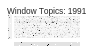

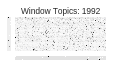

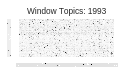

In [ ]:
import seaborn as sns; sns.set()

docs = Doc.objects.filter(query=q)

dtms = []

Ws = []

Hs = []


for y in [1991,1992,1993,1994,1995,1996]:
    ydocs = docs.filter(PY=y)

    abstracts, docsizes, ids = proc_docs(ydocs, stoplist)

    tfidf_vectorizer = TfidfVectorizer(
            max_df=0.7,
            min_df=6,
            max_features=500000,
            ngram_range=(1,1),
            tokenizer=snowball_stemmer(),
            stop_words=stoplist
        )
    tfidf = tfidf_vectorizer.fit_transform(abstracts)

    dtms.append(tfidf)
    
vs = np.array([x.shape[1] for x in dtms])

ws = [x.shape[1]/vs.mean() for x in dtms]
    
for i,y in enumerate([1991,1992,1993,1994,1995,1996]):
    tfidf = dtms[i]
    
    tfidf_m = tfidf.toarray()
    tfidf_m[tfidf_m==0.0]=np.nan
    
    K = predict(ydocs.count())
    
    nmf = NMF(n_components=K, random_state=1,
              alpha=0.2, l1_ratio=.1, verbose=False,
              init='nndsvd', max_iter=100).fit(tfidf)
    
    W = coo_matrix(nmf.components_)
    
    Ws.append(W)


    W_m = W.toarray()
    W_m[W_m>0.5]=0.5
    W_m[(W_m<0.3) & (W_m>0.0005)]=0.1
    W_m[W_m==0.0]=np.nan
    
    H = coo_matrix(nmf.transform(tfidf))
    
    Hs.append(H)

    H_m = H.toarray()
    H_m[(H_m<0.3) & (H_m>0.0005)]=0.1
    H_m[H_m==0.0]=np.nan
    
    plt.rcParams["figure.figsize"] = [29.7/6/2.54*ws[i],29.7/6/2.54*0.6*ws[i]]

    fig = plt.figure()


    ###
    ax1 = fig.add_axes([-0.45,0.5  ,0.8  ,0.5])
    ax2 = fig.add_axes([0    ,0.15 ,0.8  ,0.5])
    ax3 = fig.add_axes([0    ,0.5  ,0.8  ,0.5])
    #ax4 = fig.add_axes([0.825,0.5  ,0.02 ,0.5])

    tfidf_m = tfidf.toarray()
    tfidf_m[tfidf_m==0.0]=np.nan

    sns.heatmap(
        H_m,
        xticklabels=False,
        yticklabels=False,
        cmap="Greys",
        square=True,
        ax=ax1,
        cbar=False
    )

    sns.heatmap(
        W_m,xticklabels=False,yticklabels=False,cmap="Greys",square=True,
        ax=ax2,
        #cbar_ax=ax4
        cbar=False
    )

    sns.heatmap(
        tfidf_m,
        xticklabels=False,
        yticklabels=False,
        cmap="Greys",
        square=True,
        ax=ax3,
        #cbar_ax=ax4,
        cbar=False
    )

    m = tfidf_m.shape[0] # docs
    n = tfidf_m.shape[1] # terms
    r = H_m.shape[1] # topics

    #ax1.text(H_m.shape[1]*4,H_m.shape[0]/2,"H:\n{}\nx\n{}".format(H_m.shape[1],H_m.shape[0]),
    #        va="center", ha="center")

    #ax1.text(H_m.shape[1]/2,-H_m.shape[0]/5,r'V$\approx$WH',ha="center")
    #ax2.text(W_m.shape[1]/2,W_m.shape[0]*2,"W: {} x {}".format(W_m.shape[1],W_m.shape[0]))
    #ax3.text(n*0.5,m*1.08,"V: {} x {}".format(n,m))
    
    st = fig.suptitle("Window Topics: {}".format(y), fontsize="x-small",ha="center")
    st.set_y(1.15)
    st.set_x(0.4)

    #fig.tight_layout()
    plt.savefig('../plots/VWH_{}.png'.format(y),bbox_inches='tight')

    plt.show()

In [73]:
vs = np.array([x.shape[1] for x in dtms])



vs.mean()

ws = [x.shape[1]/vs.mean() for x in dtms]

ws

[0.58364953432218003,
 0.8113142462918248,
 0.91272852707830288,
 1.0451879958606416,
 1.3163159710244912,
 1.3308037254225595]

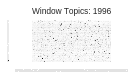

In [63]:
    plt.rcParams["figure.figsize"] = [29.7/6/2.54,29.7/6/2.54*0.6]

    fig = plt.figure()

###
    ax1 = fig.add_axes([-0.45,0.5  ,0.8  ,0.5])
    ax2 = fig.add_axes([0    ,0.15 ,0.8  ,0.5])
    ax3 = fig.add_axes([0    ,0.5  ,0.8  ,0.5])
    #ax4 = fig.add_axes([0.825,0.5  ,0.02 ,0.5])

    tfidf_m = tfidf.toarray()
    tfidf_m[tfidf_m==0.0]=np.nan

    sns.heatmap(
        H_m,
        xticklabels=False,
        yticklabels=False,
        cmap="Greys",
        square=True,
        ax=ax1,
        cbar=False
    )

    sns.heatmap(
        W_m,xticklabels=False,yticklabels=False,cmap="Greys",square=True,
        ax=ax2,
        #cbar_ax=ax4
        cbar=False
    )

    sns.heatmap(
        tfidf_m,
        xticklabels=False,
        yticklabels=False,
        cmap="Greys",
        square=True,
        ax=ax3,
        #cbar_ax=ax4,
        cbar=False
    )

    m = tfidf_m.shape[0] # docs
    n = tfidf_m.shape[1] # terms
    r = H_m.shape[1] # topics

    #ax1.text(H_m.shape[1]*4,H_m.shape[0]/2,"H:\n{}\nx\n{}".format(H_m.shape[1],H_m.shape[0]),
    #        va="center", ha="center")

    #ax1.text(H_m.shape[1]/2,-H_m.shape[0]/5,r'V$\approx$WH',ha="center")
    #ax2.text(W_m.shape[1]/2,W_m.shape[0]*2,"W: {} x {}".format(W_m.shape[1],W_m.shape[0]))
    #ax3.text(n*0.5,m*1.08,"V: {} x {}".format(n,m))
    
    st = fig.suptitle("Window Topics: {}".format(y), fontsize="x-small",ha="center")
    st.set_y(1.15)
    st.set_x(0.4)

    #fig.tight_layout()
    plt.savefig('../plots/VWH_{}.png'.format(y),bbox_inches='tight')

    plt.show()

In [49]:
from scipy.sparse import hstack, vstack, csr_matrix
#empty_ts = csr_matrix()

np.zeros(3)

for i,x in enumerate(reversed(Ws)):
    print(x.shape)
    if i == 0:
        total = x.shape[1]
        W_W = x
    else:
        nrs = total - x.shape[1]
        nm = csr_matrix((x.shape[0],nrs))
        exm = hstack([x,nm])
        W_W = vstack([W_W,exm])

W_W

tfidf_m = W_W.toarray()

tfidf_m[(tfidf_m<0.5) & (tfidf_m>0.0005)]=0.5
tfidf_m[tfidf_m==0.0]=np.nan

(53, 1929)
(52, 1908)
(50, 1515)
(49, 1323)
(48, 1176)
(47, 846)


In [14]:
W_W

<299x1929 sparse matrix of type '<class 'numpy.float64'>'
	with 92105 stored elements in COOrdinate format>

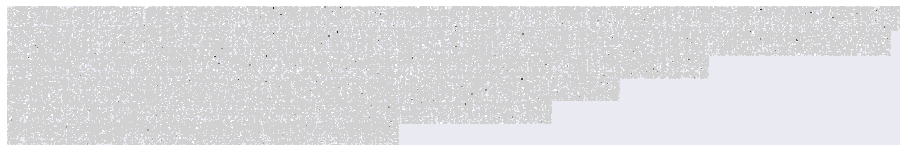

In [15]:

import seaborn as sns; sns.set()

plt.rcParams["figure.figsize"] = [16,16]

ax = sns.heatmap(tfidf_m,xticklabels=False,yticklabels=False,cmap="Greys",square=True,cbar=False)

plt.savefig('../plots/V_B.png'.format(y),bbox_inches='tight')

plt.show()

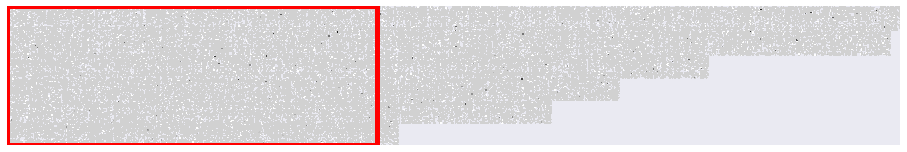

In [16]:
nsize= 800

import seaborn as sns; sns.set()

plt.rcParams["figure.figsize"] = [16,16]

ax = sns.heatmap(tfidf_m,xticklabels=False,yticklabels=False,cmap="Greys",square=True,cbar=False)

ax.bar(nsize/2,tfidf_m.shape[0],width=nsize,fill=None,edgecolor="red",linewidth=5)

plt.savefig('../plots/V_B_cut.png'.format(y),bbox_inches='tight')

plt.show()

In [50]:
B = W_W.tocsr()[:,:nsize]
B.shape

tfidf_m = B.toarray()

tfidf_m[(tfidf_m<0.5) & (tfidf_m>0.0005)]=0.5
tfidf_m[tfidf_m==0.0]=np.nan

2062


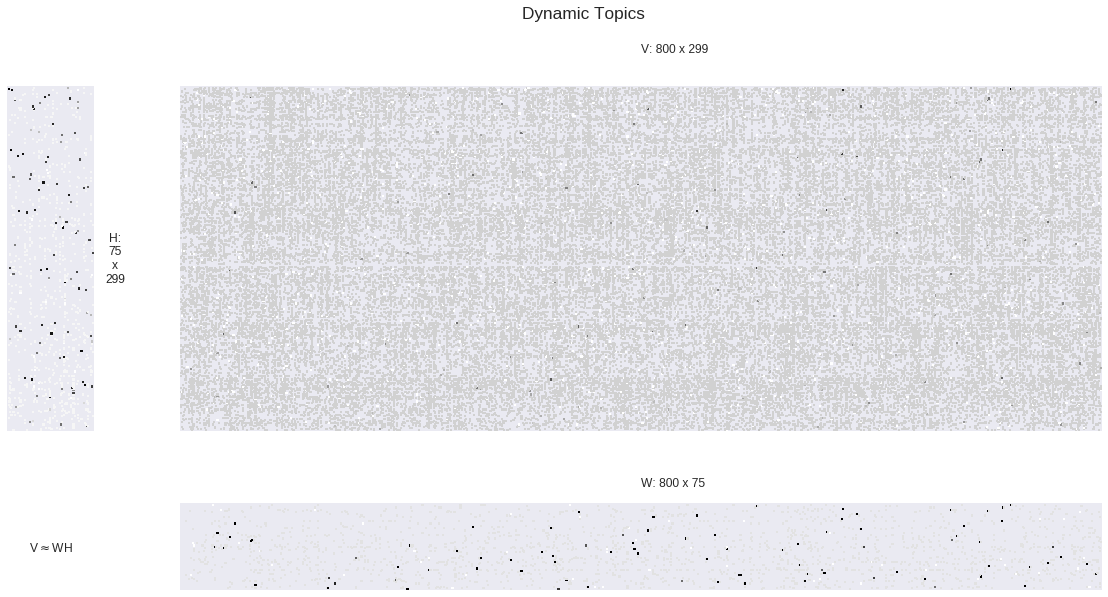

In [51]:
nmf = NMF(
    n_components=75, random_state=1,
    alpha=.1, l1_ratio=.5
).fit(B)


W = coo_matrix(nmf.components_)

print(len(find(W)[0]))

W_m = W.toarray()
W_m[W_m>0.5]=0.5
W_m[(W_m<0.3) & (W_m>0.0005)]=0.1
W_m[W_m==0.0]=np.nan

H = coo_matrix(nmf.transform(B))

H_m = H.toarray()
H_m[(H_m<0.3) & (H_m>0.0005)]=0.1
H_m[H_m==0.0]=np.nan

plt.rcParams["figure.figsize"] = [16,10]

fig = plt.figure()

st = fig.suptitle("Dynamic Topics", fontsize="x-large",ha="center")

### left, bottom, width, height
#ax1 = fig.add_axes([-0.45,0.5  ,0.8  ,0.5])
#ax1 = fig.add_axes([-0.05,0.5  , 0.023  ,0.5])
#ax2 = fig.add_axes([0    ,0.35 ,0.8  ,0.5])
#ax3 = fig.add_axes([0    ,0.5  ,0.8  ,0.5])
#ax4 = fig.add_axes([0.825,0.5  ,0.02 ,0.5])


ax1 = fig.add_axes([0.0,0.5  , 0.075,0.5])
ax2 = fig.add_axes([0.15    ,0.1  ,0.8  ,0.5])
ax3 = fig.add_axes([0.15    ,0.5  ,0.8  ,0.5])

sns.heatmap(
    tfidf_m,
    xticklabels=False,
    yticklabels=False,
    cmap="Greys",
    square=True,
    ax=ax3,
    #cbar_ax=ax4
    cbar=False
)

sns.heatmap(
    H_m,
    xticklabels=False,
    yticklabels=False,
    cmap="Greys",
    square=True,
    ax=ax1,
    cbar=False
)

sns.heatmap(
    W_m,xticklabels=False,yticklabels=False,cmap="Greys",square=True,
    ax=ax2,
    #cbar_ax=ax4
    cbar=False
)



m = tfidf_m.shape[0] # docs
n = tfidf_m.shape[1] # terms
r = H_m.shape[1] # topics

ax1.text(H_m.shape[1]*1.25,H_m.shape[0]/2,"H:\n{}\nx\n{}".format(H_m.shape[1],H_m.shape[0]),
        va="center", ha="center")

ax1.text(H_m.shape[1]/2,-H_m.shape[0]*0.35,r'V$\approx$WH',ha="center")
ax2.text(W_m.shape[1]/2,W_m.shape[0]*1.2,"W: {} x {}".format(W_m.shape[1],W_m.shape[0]))
ax3.text(n*0.5,m*1.1,"V: {} x {}".format(n,m))

#fig.tight_layout()

st.set_y(1.1)



plt.savefig('../plots/VWH_B.png'.format(y),bbox_inches='tight')

plt.show()

In [10]:
H.shape

(299, 75)

In [11]:
W.shape

(75, 1000)